In [42]:
#! pip install pmdarima

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.



                                              0.0/615.0 kB ? eta -:--:--
     -                                     20.5/615.0 kB 320.0 kB/s eta 0:00:02
     ----                                  81.9/615.0 kB 907.3 kB/s eta 0:00:01
     -------------------------------------  614.4/615.0 kB 4.8 MB/s eta 0:00:01
     -------------------------------------- 615.0/615.0 kB 4.3 MB/s eta 0:00:00
                                              0.0/2.8 MB ? eta -:--:--
     -------------------------                1.8/2.8 MB 37.0 MB/s eta 0:00:01
     ---------------------------------------- 2.8/2.8 MB 29.5 MB/s eta 0:00:00


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.svar_model import SVAR
from pmdarima.arima import auto_arima

In [50]:
import warnings
warnings.filterwarnings(
    'ignore',
    message='No frequency information was provided, so inferred frequency MS will be used.'
)

In [2]:
cpi = pd.read_csv(r"E:\Senior\DATA 201\CPIAUCNS.csv", parse_dates=['observation_date'], index_col='observation_date')
ffr = pd.read_csv(r"E:\Senior\DATA 201\FEDFUNDS.csv", parse_dates=['observation_date'], index_col='observation_date')

In [3]:
cpi.columns = ['CPI']
ffr.columns = ['FFR']

df = pd.concat([cpi, ffr], axis=1).dropna().copy()
df.loc[:, 'Inflation'] = df['CPI'].pct_change() * 100
df.loc[:, 'FFR_diff']  = df['FFR'].diff()
#drop NaN
df = df.dropna(subset=['Inflation', 'FFR_diff'])

<Figure size 1000x400 with 0 Axes>

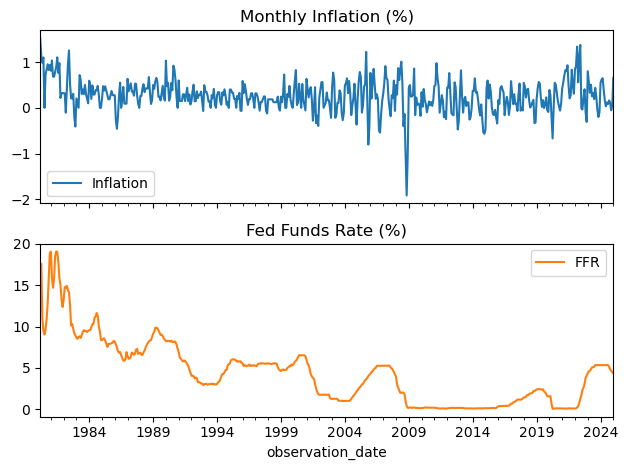

In [4]:
# compute inflation as monthly % change
df['Inflation'] = df['CPI'].pct_change() * 100
df = df.dropna()

# plot series
plt.figure(figsize=(10,4))
df[['Inflation','FFR']].plot(subplots=True, title=['Monthly Inflation (%)','Fed Funds Rate (%)'])
plt.tight_layout()
plt.show()

STATIONARITY TESTS

In [5]:
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:')
    print(f'  Test Statistic = {result[0]:.4f}')
    print(f'  p-value        = {result[1]:.4f}')
    print('  -> Stationary' if result[1]<0.05 else '  -> Non-stationary')
    print('-'*40)

In [6]:
adf_test(df['Inflation'], 'Inflation')
adf_test(df['FFR'], 'Fed Funds Rate')

ADF Test for Inflation:
  Test Statistic = -4.8028
  p-value        = 0.0001
  -> Stationary
----------------------------------------
ADF Test for Fed Funds Rate:
  Test Statistic = -2.7098
  p-value        = 0.0724
  -> Non-stationary
----------------------------------------


In [7]:
# since FFR is non-stationary, calculate the difference:
df['FFR_diff'] = df['FFR'].diff().dropna()
adf_test(df['FFR_diff'].dropna(), 'FFR (1st diff)')

ADF Test for FFR (1st diff):
  Test Statistic = -6.3193
  p-value        = 0.0000
  -> Stationary
----------------------------------------


GRANGER CAUSALITY

In [8]:
max_lag = 6 #(half a year)
grangercausalitytests(df[['Inflation','FFR_diff']].dropna(), maxlag=max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6624  , p=0.1033  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=2.6773  , p=0.1018  , df=1
likelihood ratio test: chi2=2.6707  , p=0.1022  , df=1
parameter F test:         F=2.6624  , p=0.1033  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5046  , p=0.0827  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=5.0565  , p=0.0798  , df=2
likelihood ratio test: chi2=5.0328  , p=0.0808  , df=2
parameter F test:         F=2.5046  , p=0.0827  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8888  , p=0.0091  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=11.8210 , p=0.0080  , df=3
likelihood ratio test: chi2=11.6923 , p=0.0085  , df=3
parameter F test:         F=3.8888  , p=0.0091  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8083  , p=0.0251  

{1: ({'ssr_ftest': (2.6623833793956106, 0.10333622452333789, 534.0, 1),
   'ssr_chi2test': (2.6773405893922155, 0.10178558006507525, 1),
   'lrtest': (2.6706884332577374, 0.1022118023770932, 1),
   'params_ftest': (2.662383379395757, 0.10333622452332716, 534.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.504643953414578, 0.08266956863407983, 531.0, 2),
   'ssr_chi2test': (5.05645634286333, 0.07980028752747578, 2),
   'lrtest': (5.032754774629666, 0.08075160932837307, 2),
   'params_ftest': (2.504643953414645, 0.08266956863407314, 531.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.888769341738904, 0.009094143548701965, 528.0, 3),
   'ssr_chi2test': (11.820974987672239, 0.008022274994808782, 3),
   'lrtest': (11.692273456962994, 0.008515197022459805, 3),
   'params_ftest': (3.8887693417389464, 0.009094143548701165, 528.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

ARIMA MODEL FOR INFLATION

<Figure size 1000x400 with 0 Axes>

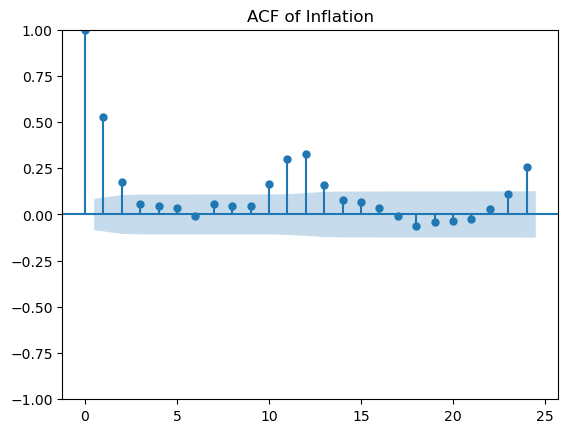

In [9]:
plt.figure(figsize=(10,4))
plot_acf(df['Inflation'], lags=24)
plt.title('ACF of Inflation'); plt.show()

<Figure size 1000x400 with 0 Axes>

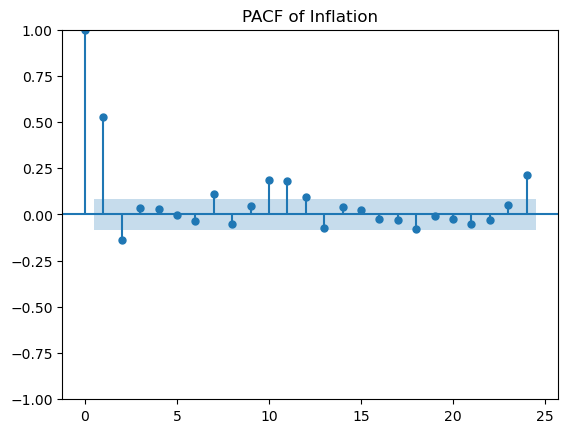

In [10]:
plt.figure(figsize=(10,4))
plot_pacf(df['Inflation'], lags=24, method='ywm')
plt.title('PACF of Inflation'); plt.show()

In [11]:
model_arima = ARIMA(df['Inflation'], order=(1,0,1))
res_arima  = model_arima.fit()
print(res_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Inflation   No. Observations:                  539
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -95.849
Date:                Tue, 06 May 2025   AIC                            199.698
Time:                        22:39:19   BIC                            216.856
Sample:                    03-01-1980   HQIC                           206.409
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2620      0.024     10.827      0.000       0.215       0.309
ar.L1          0.3596      0.051      7.049      0.000       0.260       0.460
ma.L1          0.2627      0.055      4.776      0.0

C:\Users\nguye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nguye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nguye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


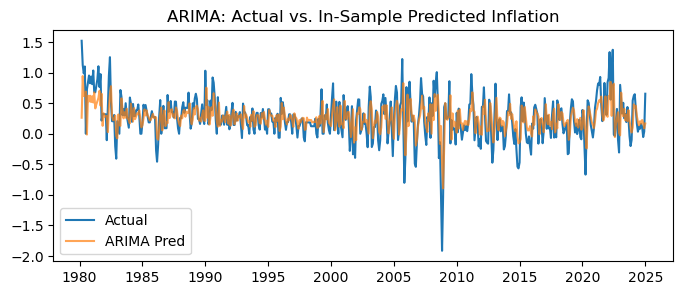

In [12]:
# one step prediction & plot
df['ARIMA_pred'] = res_arima.predict()
plt.figure(figsize=(8,3))
plt.plot(df['Inflation'], label='Actual')
plt.plot(df['ARIMA_pred'], label='ARIMA Pred', alpha=0.7)
plt.legend()
plt.title('ARIMA: Actual vs. In‑Sample Predicted Inflation')
plt.show()

In [13]:
#Fit SARIMA
model = SARIMAX(
    df['Inflation'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

C:\Users\nguye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nguye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          Inflation   No. Observations:                  539
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -33.195
Date:                            Tue, 06 May 2025   AIC                             76.390
Time:                                    22:39:20   BIC                             97.707
Sample:                                03-01-1980   HQIC                            84.737
                                     - 01-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3313      0.059      5.571      0.000       0.215       0.448
ma.L1          0.2330      0.062   

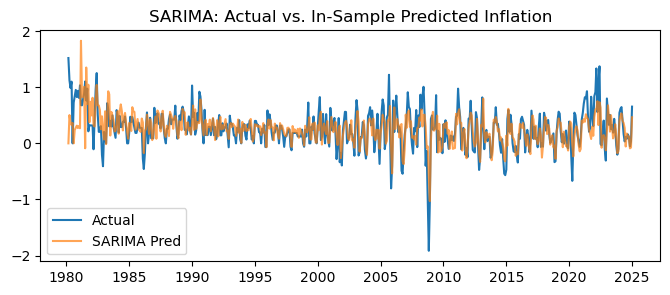

In [14]:
# one step prediction & plot (SARIMA)
df['SARIMA_pred'] = res.predict()
plt.figure(figsize=(8,3))
plt.plot(df['Inflation'], label='Actual')
plt.plot(df['SARIMA_pred'], label='SARIMA Pred', alpha=0.7)
plt.legend()
plt.title('SARIMA: Actual vs. In‑Sample Predicted Inflation')
plt.show()

VAR MODEL (INFLATION & FFR_DIFF)

In [15]:
var_df = df[['Inflation','FFR_diff']].dropna()
# select lag order by AIC
model_var = VAR(var_df)
lag_order = model_var.select_order(maxlags=12)
print(lag_order.summary())

# fit VAR with chosen lag (2)
res_var = model_var.fit(lag_order.bic)
print(res_var.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.454      -4.438     0.01163      -4.448
1       -5.012      -4.963    0.006658      -4.993
2       -5.060     -4.979*    0.006348      -5.028
3       -5.051      -4.937    0.006405      -5.006
4       -5.045      -4.899    0.006439      -4.988
5       -5.065      -4.887    0.006311      -4.996
6       -5.058      -4.847    0.006359      -4.975
7       -5.077      -4.834    0.006240      -4.982
8       -5.092      -4.817    0.006144      -4.984
9       -5.082      -4.774    0.006209      -4.961
10      -5.154      -4.813    0.005777      -5.021
11      -5.195      -4.822    0.005544      -5.049
12     -5.235*      -4.830   0.005326*     -5.077*
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, May

C:\Users\nguye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


FORECASTING & EVALUATION

VAR Forecast MAE=0.195, RMSE=0.216


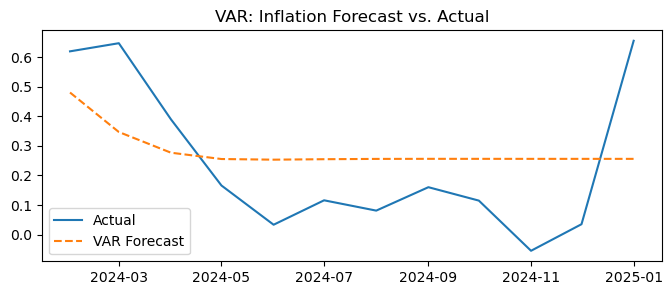

In [16]:
# define train/test split
n_test = 12
train, test = var_df[:-n_test], var_df[-n_test:]

# forecast with VAR
forecast = res_var.forecast(train.values[-res_var.k_ar:], steps=n_test)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=var_df.columns)

# evaluate Inflation forecasts
mae = mean_absolute_error(test['Inflation'], forecast_df['Inflation'])
rmse = np.sqrt(mean_squared_error(test['Inflation'], forecast_df['Inflation']))
print(f'VAR Forecast MAE={mae:.3f}, RMSE={rmse:.3f}')

# plot
plt.figure(figsize=(8,3))
plt.plot(test['Inflation'], label='Actual')
plt.plot(forecast_df['Inflation'], label='VAR Forecast', linestyle='--')
plt.legend()
plt.title('VAR: Inflation Forecast vs. Actual')
plt.show()

RESIDUAL TEST

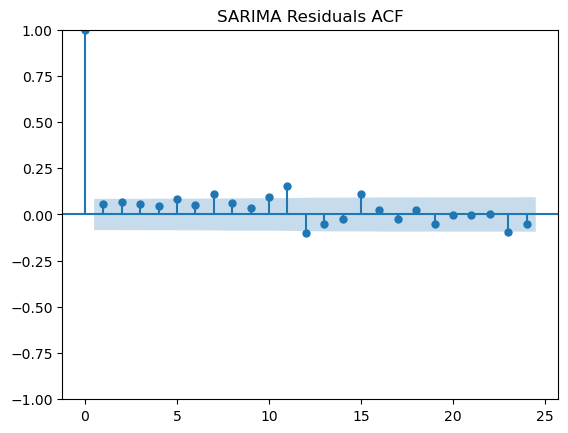

Ljung-Box test (SARIMA residuals):
      lb_stat  lb_pvalue
24  63.773201   0.000018


In [17]:
# ACF of residuals from SARIMA
sm.graphics.tsa.plot_acf(res.resid.dropna(), lags=24, title='SARIMA Residuals ACF')
plt.show()

# Ljung-Box
lb_test = sm.stats.acorr_ljungbox(res.resid.dropna(), lags=[24], return_df=True)
print('Ljung-Box test (SARIMA residuals):')
print(lb_test)

In [ ]:
#Comparison between 2 periods (Volcker Era vs. Great Moderation)

In [34]:
df1 = df[['CPI', 'FFR', 'Inflation', 'FFR_diff']]

In [35]:
volcker = df1['1980-01-01':'1992-12-31']
great_mod = df1['1993-01-01':'2007-12-31']

In [37]:
#Granger Causality Comparison
def granger_compare(d, label, maxlag=6):
    print(f"Granger ΔFFR → Inflation — {label}")
    data = d[['Inflation','FFR_diff']].dropna()
    for lag in range(1, maxlag+1):
        pvalue = grangercausalitytests(data, maxlag=lag, verbose=False)[lag][0]['ssr_ftest'][1]
        print(f"  lag {lag:2d}: p = {pvalue:.3f}")
    print()

In [38]:
granger_compare(volcker,   "Volcker Era")
granger_compare(great_mod, "Great Moderation")

Granger ΔFFR → Inflation — Volcker Era
  lag  1: p = 0.089
  lag  2: p = 0.005
  lag  3: p = 0.001
  lag  4: p = 0.007
  lag  5: p = 0.002
  lag  6: p = 0.000

Granger ΔFFR → Inflation — Great Moderation
  lag  1: p = 0.098
  lag  2: p = 0.110
  lag  3: p = 0.039
  lag  4: p = 0.033
  lag  5: p = 0.065
  lag  6: p = 0.110



In [44]:
# Auto ARIMA comparison
vol_auto = auto_arima(
    volcker['Inflation'],
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,               
    seasonal=True,
    m=12,                 
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    D=None,               
    information_criterion='bic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

gm_auto = auto_arima(
    great_mod['Inflation'],
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    seasonal=True,
    m=12,
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    D=None,
    information_criterion='bic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=59.319, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=54.924, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=47.631, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=54.493, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=45.017, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : BIC=47.144, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : BIC=31.400, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : BIC=30.919, Time=0.42 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=30.683, Time=0.47 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : BIC=32.096, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : BIC=34.780, Time=0.67 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : BIC=35.111, Time=0.47 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=53.711, Ti

In [46]:
def sarima_analysis(d, label, order, seasonal_order, holdout=12):
    
    print(f"\n=== {label} SARIMA{order}×{seasonal_order} Analysis ===\n")

    # Fit SARIMA model
    model = SARIMAX(
        d['Inflation'],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    print(res.summary())

    # Residual diagnostics
    resid = res.resid.dropna()
    print("\n-- Ljung–Box Test (lags 12 & 24) --")
    lb = sm.stats.acorr_ljungbox(resid, lags=[12, 24], return_df=True)
    print(lb)
    print("\n-- Jarque–Bera Test --")
    jb = sm.stats.jarque_bera(resid)
    print(f" JB stat = {jb[0]:.3f}, p-value = {jb[1]:.3f}")

    # Plot residual ACF
    sm.graphics.tsa.plot_acf(resid, lags=24, title=f"{label}: Residual ACF")
    plt.show()

    # In-sample fit plot
    fitted = res.fittedvalues
    plt.figure(figsize=(10,4))
    plt.plot(d['Inflation'], label='Actual')
    plt.plot(fitted, label='Fitted', alpha=0.7)
    plt.title(f"{label}: Actual vs. Fitted")
    plt.legend()
    plt.show()

    # Out-of-sample forecast evaluation
    if holdout > 0 and len(d) > holdout:
        train = d[:-holdout]
        test = d[-holdout:]
        fc = res.get_forecast(steps=holdout).predicted_mean

        plt.figure(figsize=(10,4))
        plt.plot(train['Inflation'], label='Train')
        plt.plot(test['Inflation'], label='Test')
        plt.plot(test.index, fc, label='Forecast', linestyle='--')
        plt.title(f"{label}: Forecast vs. Actual")
        plt.legend()
        plt.show()

        mae = mean_absolute_error(test['Inflation'], fc)
        rmse = mean_squared_error(test['Inflation'], fc, squared=False)
        print(f"\nForecast MAE = {mae:.3f}, RMSE = {rmse:.3f}")

    return res


=== Volcker Era (1980–1992) SARIMA(1, 1, 1)×(1, 0, 1, 12) Analysis ===

                                     SARIMAX Results                                      
Dep. Variable:                          Inflation   No. Observations:                  154
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                   6.889
Date:                            Wed, 07 May 2025   AIC                             -3.777
Time:                                    00:23:45   BIC                             10.895
Sample:                                03-01-1980   HQIC                             2.185
                                     - 12-01-1992                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5115      0.078      6.5

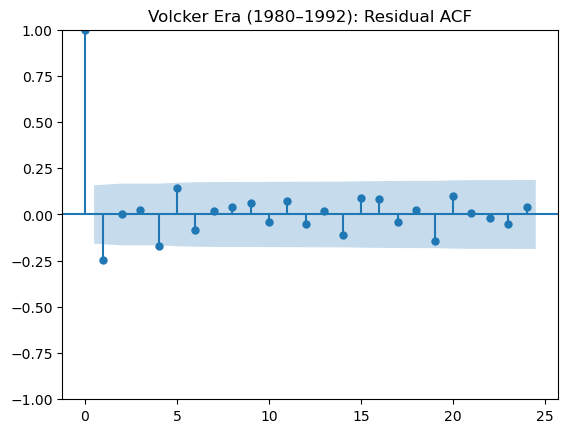

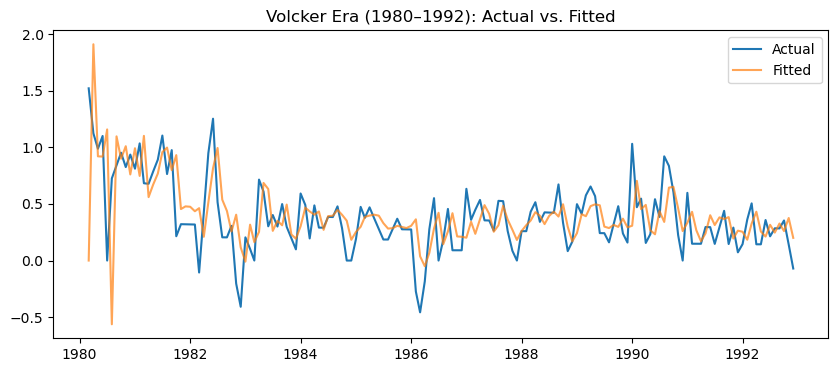

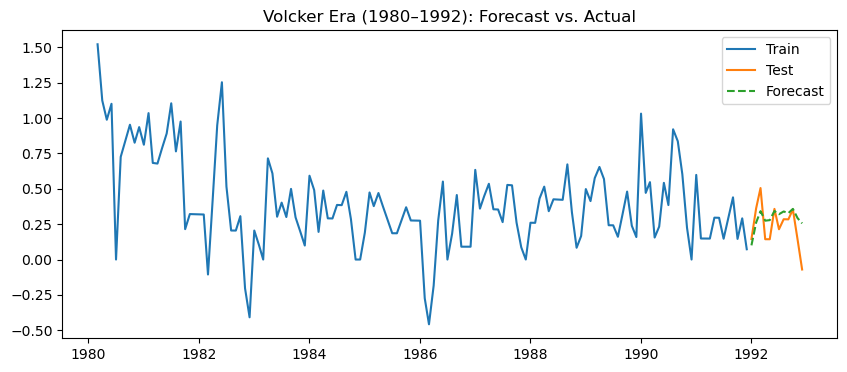


Forecast MAE = 0.106, RMSE = 0.135


In [51]:
volcker_res = sarima_analysis(
    volcker,
    "Volcker Era (1980–1992)",
    order=(1,1,1),
    seasonal_order=(1,0,1,12)
)


=== Great Moderation (1993–2007) SARIMA(0, 0, 3)×(1, 0, 1, 12) Analysis ===

                                      SARIMAX Results                                       
Dep. Variable:                            Inflation   No. Observations:                  180
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                   3.472
Date:                              Wed, 07 May 2025   AIC                              5.056
Time:                                      00:23:47   BIC                             23.655
Sample:                                  01-01-1993   HQIC                            12.606
                                       - 12-01-2007                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.340

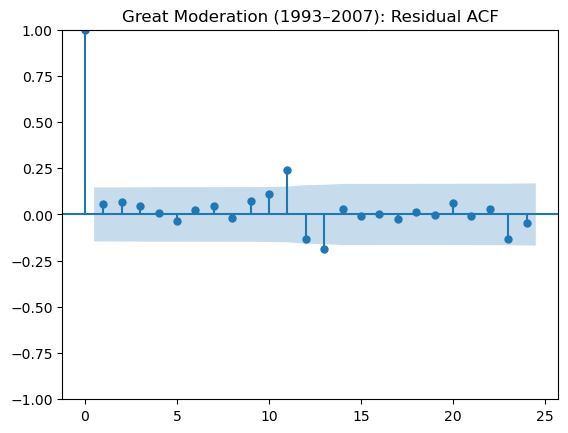

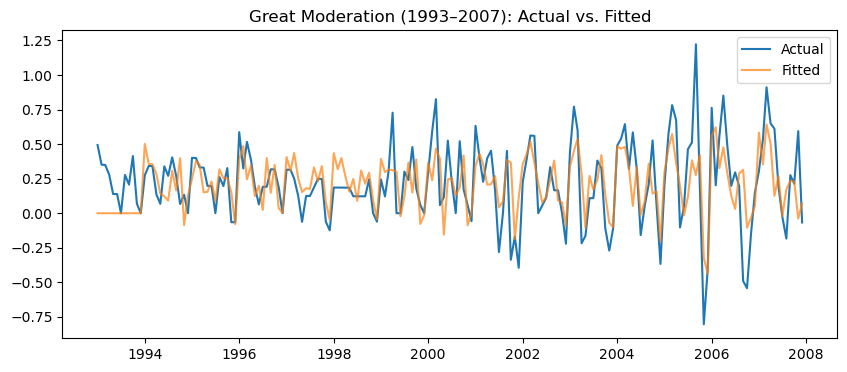

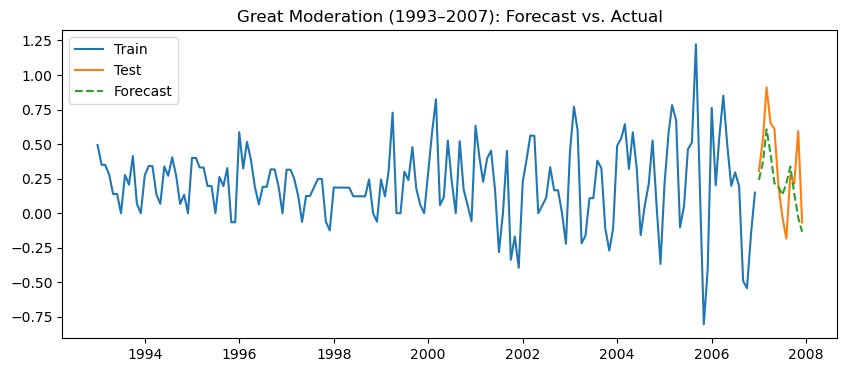


Forecast MAE = 0.211, RMSE = 0.276


In [52]:
gm_res = sarima_analysis(
    great_mod,
    "Great Moderation (1993–2007)",
    order=(0,0,3),
    seasonal_order=(1,0,1,12)
)

In [77]:
def plot_cholesky_irf(df, maxlags, ic, irf_periods):
    #Fit VAR and select lag order
    var_mod = VAR(df)
    var_res = var_mod.fit(maxlags=maxlags, ic=ic)
    p = var_res.k_ar
    
    #Compute orthogonalized IRFs
    irf = var_res.irf(irf_periods)
    
    #Plot
    fig = irf.plot(orth=True)
    plt.suptitle("Orthogonalized (Cholesky) IRFs (VAR order = {})".format(p))
    plt.tight_layout()
    plt.show()
    
    return var_res, irf

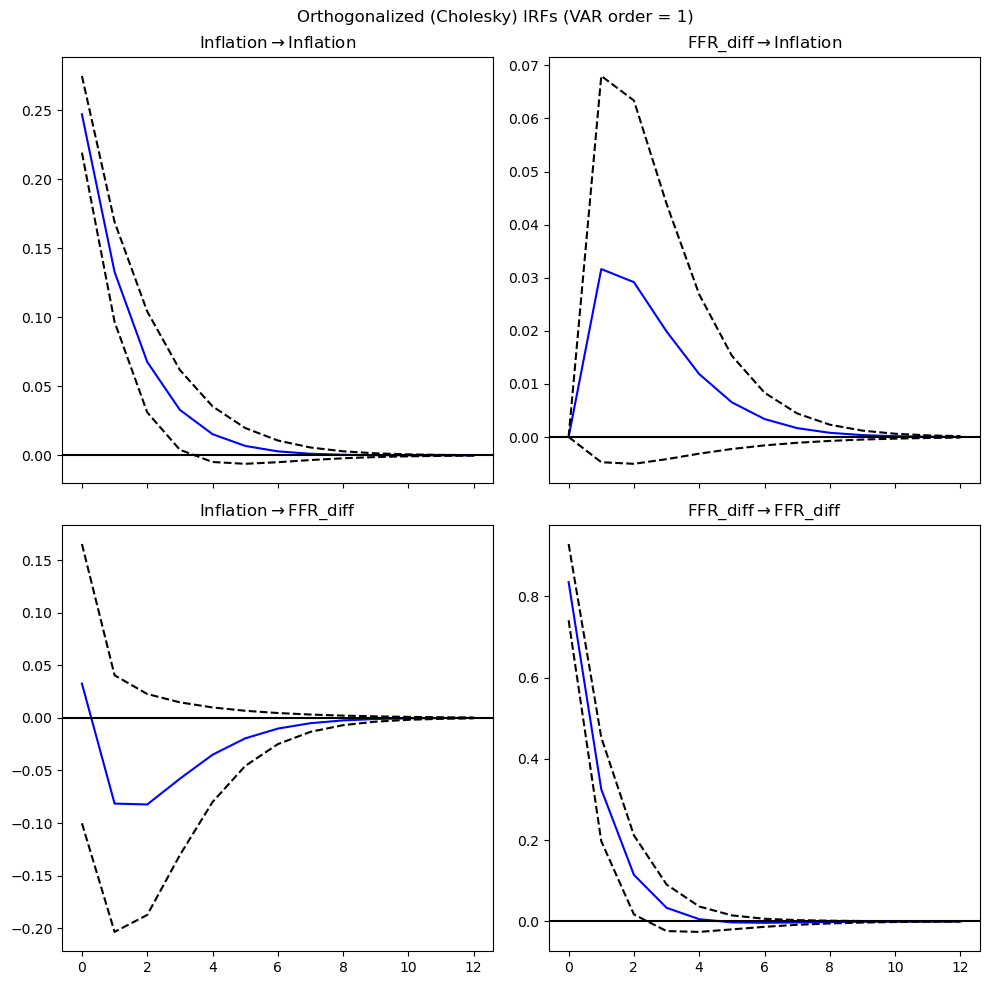

In [79]:
volcker_results, volcker_irf = plot_cholesky_irf(volcker[['Inflation','FFR_diff']].dropna(), 6, ic='bic', irf_periods=12)

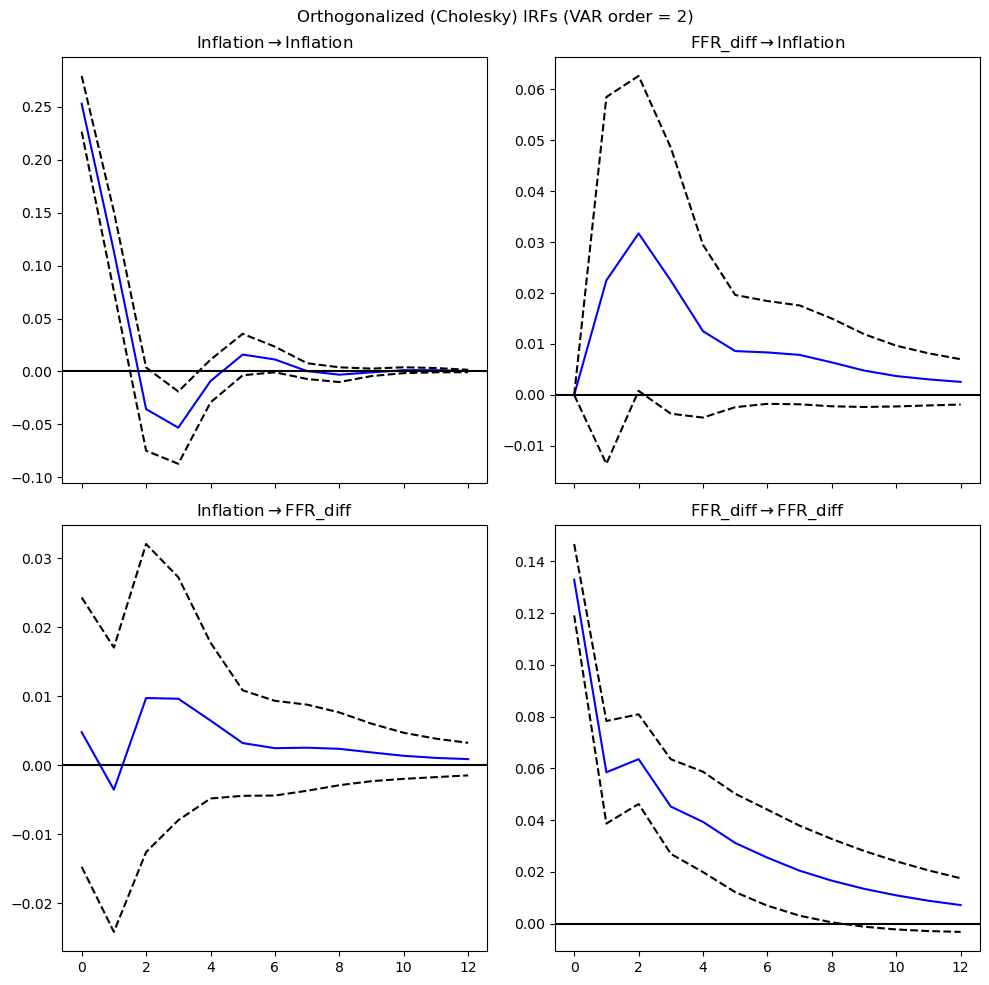

In [80]:
gm_results, gm_irf = plot_cholesky_irf(great_mod[['Inflation','FFR_diff']].dropna(), 6, ic='bic', irf_periods=12)